In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [32]:
# Parameter settings
TRAIN_DIR = 'dataset/train'
VAL_DIR   = 'dataset/val'
TEST_DIR  = 'dataset/test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
SAVE_DIR = 'models'
os.makedirs(SAVE_DIR, exist_ok=True)

In [33]:
# Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [34]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11418 images belonging to 7 classes.
Found 1430 images belonging to 7 classes.


In [35]:
# Get number of classes
num_classes = train_generator.num_classes
class_names = train_generator.class_indices
print("Classes:", class_names)

Classes: {'cardboard': 0, 'e-waste': 1, 'glass': 2, 'medical': 3, 'metal': 4, 'paper': 5, 'plastic': 6}


In [39]:
# Optional: compute simple class weights to handle imbalance
from collections import Counter
counts = Counter(train_generator.classes)
total = sum(counts.values())
class_weights = {i: total/(num_classes*counts[i]) for i in range(num_classes)}
print("Class weights:", class_weights)

Class weights: {0: 1.056439674315322, 1: 0.8482282148428795, 2: 1.0093705799151345, 3: 1.303871188763275, 4: 0.9861806875107963, 5: 0.9466876710057209, 6: 0.9555611348229978}


In [40]:
# Load MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers
base_model.trainable = False

In [41]:
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 256)               327936    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                      

In [43]:
# Early stopping callback for better training
ckpt_path = os.path.join(SAVE_DIR, 'best_model.h5')
callbacks = [
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

In [44]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/25
  5/357 [..............................] - ETA: 11:46 - loss: 2.5425 - accuracy: 0.2500

c:\Users\ADMIN\trash-classifer\venv\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


357/357 [==============================] - ETA: 0s - loss: 1.0175 - accuracy: 0.6847
Epoch 1: val_loss improved from inf to 0.56425, saving model to models\best_model.h5
357/357 [==============================] - 695s 2s/step - loss: 1.0175 - accuracy: 0.6847 - val_loss: 0.5643 - val_accuracy: 0.8154 - lr: 0.0010
Epoch 2/25
357/357 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.7816
Epoch 2: val_loss improved from 0.56425 to 0.51543, saving model to models\best_model.h5
357/357 [==============================] - 627s 2s/step - loss: 0.6502 - accuracy: 0.7816 - val_loss: 0.5154 - val_accuracy: 0.8238 - lr: 0.0010
Epoch 3/25
357/357 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.8078
Epoch 3: val_loss improved from 0.51543 to 0.48509, saving model to models\best_model.h5
357/357 [==============================] - 604s 2s/step - loss: 0.5600 - accuracy: 0.8078 - val_loss: 0.4851 - val_accuracy: 0.8336 - lr: 0.0010
Epoch 4/25
357/357 [=====

In [45]:
# -------- Optional: fine-tune top of backbone ----------
# Unfreeze some layers and fine-tune with lower LR if desired
base_model.trainable = True
# freeze first N layers to keep low-level features
fine_tune_at = len(base_model.layers) - 50
for i, layer in enumerate(base_model.layers):
    layer.trainable = True if i >= fine_tune_at else False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS//2,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/12
357/357 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.7867
Epoch 1: val_loss did not improve from 0.42696
357/357 [==============================] - 1024s 3s/step - loss: 0.6223 - accuracy: 0.7867 - val_loss: 0.4777 - val_accuracy: 0.8503 - lr: 1.0000e-05
Epoch 2/12
357/357 [==============================] - ETA: 0s - loss: 0.4913 - accuracy: 0.8286
Epoch 2: val_loss did not improve from 0.42696
357/357 [==============================] - 1009s 3s/step - loss: 0.4913 - accuracy: 0.8286 - val_loss: 0.4714 - val_accuracy: 0.8517 - lr: 1.0000e-05
Epoch 3/12
357/357 [==============================] - ETA: 0s - loss: 0.4317 - accuracy: 0.8489
Epoch 3: val_loss did not improve from 0.42696
357/357 [==============================] - 1005s 3s/step - loss: 0.4317 - accuracy: 0.8489 - val_loss: 0.4657 - val_accuracy: 0.8629 - lr: 1.0000e-05
Epoch 4/12
357/357 [==============================] - ETA: 0s - loss: 0.3756 - accuracy: 0.8676
Epoch 4: val_loss did not

In [47]:
# -------- Evaluate on test set ----------
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
loss, acc = model.evaluate(test_gen)
print(f"Test accuracy: {acc:.4f}, loss: {loss:.4f}")

Found 1431 images belonging to 7 classes.
45/45 [==============================] - 63s 1s/step - loss: 0.4587 - accuracy: 0.8658
Test accuracy: 0.8658, loss: 0.4587


In [48]:
# Save final model (h5 + SavedModel)
final_h5 = os.path.join(SAVE_DIR, 'waste_model_final(v1).h5')
model.save(final_h5)
print("Saved model to:", final_h5)

Saved model to: models\waste_model_final(v1).h5


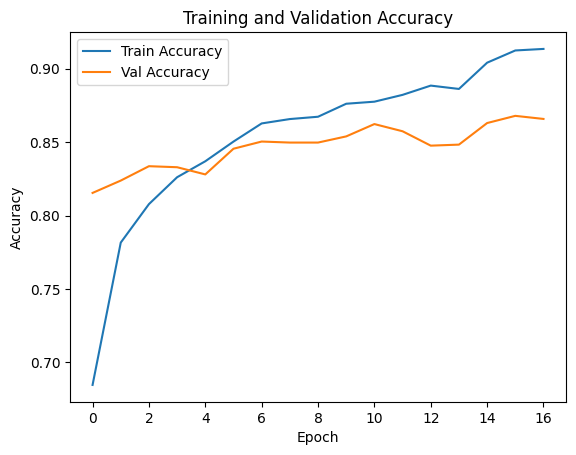

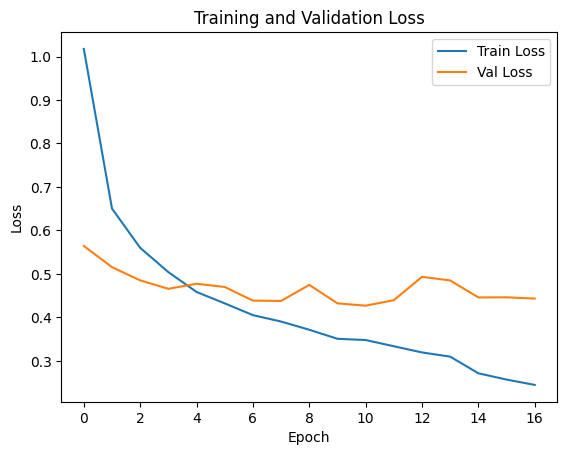

In [49]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [50]:
import numpy as np
from sklearn.metrics import classification_report

# Get predictions for the test set
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Print classification report
print(classification_report(test_gen.classes, y_pred, target_names=list(test_gen.class_indices.keys())))

 7/45 [===>..........................] - ETA: 51s

c:\Users\ADMIN\trash-classifer\venv\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


45/45 [==============================] - 67s 1s/step
              precision    recall  f1-score   support

   cardboard       0.82      0.92      0.86       193
     e-waste       0.94      0.90      0.92       241
       glass       0.81      0.92      0.86       203
     medical       0.86      0.80      0.83       157
       metal       0.91      0.90      0.91       207
       paper       0.89      0.80      0.84       216
     plastic       0.84      0.81      0.83       214

    accuracy                           0.87      1431
   macro avg       0.87      0.86      0.86      1431
weighted avg       0.87      0.87      0.87      1431

